(this notebook is modified by kevin zhu for SYDE 522. The original notebook is from https://colab.research.google.com/drive/1kcP9rsbQLDdKyzv9RUUS7aVei_28VgF6?usp=sharing#scrollTo=pqRJ07if-OXK)

# Principal component analysis

<u>**What:**</u> 

**PCA** is a <u>linear dimensionality reduction</u> method that attempts to find linear combinations of features in the original high dimensional data space to construct meaningful representations of the dataset.

<u>**How:**</u> 

PCA finds <u>linearly uncorrelated orthogonal axes</u> known as **principal components (PCs)** in the *m* dimensional space to project the data points onto those PCs. The first PC captures the largest variance in the data. 

---

References:
- https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8
- https://towardsdatascience.com/svd-8c2f72e264f

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

%matplotlib inline

### Create toy data

Let’s fit PCA on a fake 2D dataset (size: 400 x 2)

In [1]:
n = 400

# generate data along random line (y = mx + c)
np.random.seed(711)
m = np.random.randint(1, 10)
c = np.random.randint(1, 10)
x1 = np.random.randint(-20, 20, size=(n))

y1 = m*x1 + c

# add random noise
noise = np.random.rand(n) * np.random.randint(-35,35,size=n)

#make the noise orthogonal to the line y=mx+c and add it.
x=x1 + noise*m/np.sqrt(1+m**2)
y=y1 + noise/np.sqrt(1+m**2)

data = np.stack((x.T, y.T), axis=-1)

# vizualize
plt.plot(x, y, 'o', color='green', markersize=5)
plt.axis([-50, 50, -90, 90])
plt.title('some fake data')

print('Size of fake data (n x m):', data.shape)
plt.show()

NameError: name 'np' is not defined

## Iterative algorithm for PCA

Since all PCs are orthogonal to each other, we can use a pair of perpendicular lines in the 2D space as the two PCs.

We rotate our pair of PCs until one of the line's direction captures the largest variance in the data. We set this line as PC1.

We project all data points onto the PCs, with the red dots on PC1 as the resultant dimension-reduced representation of the dataset (we reduced 2D data to 1D).

![](pca.gif "Iterative algorithm for PCA")

Angle (iterative algo):	 57


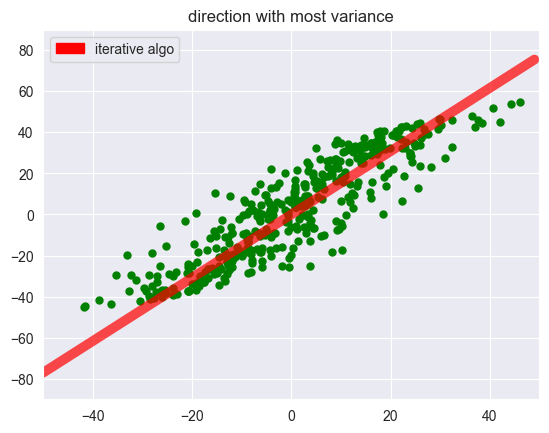

In [8]:
# centering the data i.e, mean = (0, 0)
datac = data - np.mean(data, axis=0)

def unit_vector(angle):
    angle_rad = np.deg2rad(angle)
    return np.array([[np.cos(angle_rad)], [np.sin(angle_rad)]])

# find direction with the highest variance in data
max_var_ang = np.argmax([np.var(np.dot(datac, unit_vector(i))) for i in range(180)])
# direction with least variance
#min_var_ang = np.argmin([np.var(np.dot(data, unit_vector(i))) for i in range(180)])

#-----------------------------------------------------------------------------
# plot
def draw_line(ang, rng=[-50, 50], color='red', linewidth = 1.5, alpha = 0.7):
    m = np.tan(np.deg2rad(ang))
    x = np.arange(rng[0], rng[1])
    y = x * m
    plt.plot(x, y, '-', linewidth= linewidth, color=color, alpha = alpha)

plt.plot(data[:, 0], data[:, 1], 'o', color='green', markersize=5)
draw_line(max_var_ang, linewidth=7, alpha = 0.7)
#draw_line(min_var_ang, rng=[-30, 30], color='orange')
max_patch = mpatches.Patch(color='red', label='iterative algo')
plt.legend(handles=[max_patch])
plt.axis([-50, 50, -90, 90])
plt.title('direction with most variance')

print("Angle (iterative algo):\t {0}".format(max_var_ang))

plt.show()

## PCA via eigendecomposition

This is essentially performing eigendecomposition on covariance matrix $C = cov(X)$.

$$C=W\Lambda W^{-1} $$

- $cov(X)=\frac{X^\intercal X}{n-1}$ when $X$ is centered around 0. 
- The eigenvectors (column vectors of $W$) are the PCs. The eigenvector corresponding to the largest eigenvalue is PC1.

To reduce the dimension of our data $X$ to $k$ dimensions (represented by $X_k$), we project the data points  onto the first $k$ PCs (corresponds to the first $k$ columns of $W$):

$$ X_k = XW_{:,:k} $$

In [15]:
""" 
Performs PCA using eigendecomposition.
Reduces data of m-dimensions to k<=m.

Args:
    X (n x m): dataset of m-dimensions with n observations.
    k: number of dimensions to reduce to. k <= m.

Returns:
    Xk (n x k): data represented in a lower dimension k.
    PCk (m x k): matrix with k principal components (PC) as columns. Column 1 refers to PC1.
"""

# use numpy!
def pca_eigendecomp(X, k):
    # Data matrix X
    n, m = X.shape
    Xc = X - np.mean(X, axis=0) # center X at 0
 
    # step 1: Compute covariance matrix C from Xc
    C = np.dot(Xc.T, Xc) / (n-1)
    print('C shape', C.shape)
      
    # step 2: Eigendecomposition of C (use numpy.linalg.eig)
    eigen_vals, eigen_vecs = np.linalg.eig(C)
    print('eigen vals', eigen_vals)
    print('eigen vecs', eigen_vecs)
 
    # step 3: sort eigenvectors by eigenvalues (largest eigenvalue corresponds to PC1)
    # take first k eigenvector columns as PCk
    sort_idx = np.argsort(eigen_vals)[::-1]
    PC = eigen_vecs[:, sort_idx]
    PCk = PC[:,: min(k,m)]
 
    # step 4: Project X onto first k PCs to get Xk
    Xk = np.dot(Xc, PCk)
    print('Xk shape', Xk.shape)
 
    return Xk, PCk

In [16]:
Xk_eig, PCk_eig = pca_eigendecomp(data, k=1)

C shape (2, 2)
eigen vals [ 39.8013723  841.81913821]
eigen vecs [[-0.84300478 -0.53790607]
 [ 0.53790607 -0.84300478]]
Xk shape (400, 1)


C shape (2, 2)
eigen vals [ 39.8013723  841.81913821]
eigen vecs [[-0.84300478 -0.53790607]
 [ 0.53790607 -0.84300478]]
Xk shape (400, 1)
Angle from iterative algo (red):	 57
Angle from eigendecomp (blue):	 57.45879037314545


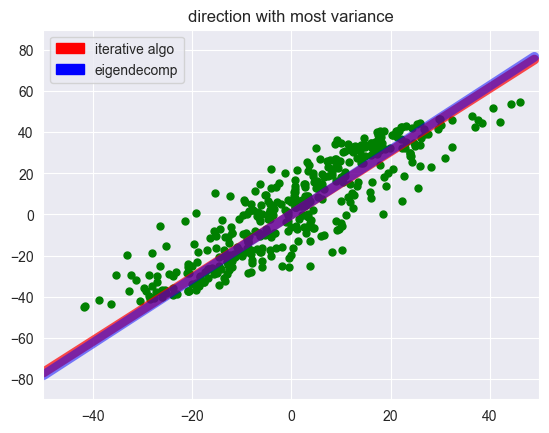

In [17]:
# apply our PCA implementation using eigendecomp on the fake data
Xk_eig, PCk_eig = pca_eigendecomp(data, k=1)

# direction with most variance computed from PC1
pca_eig_ang = np.abs(np.rad2deg(np.arctan(PCk_eig[1][0]/PCk_eig[0][0])))

#-----------------------------------------------------------------------------
# plot
print("Angle from iterative algo (red):\t {0}".format(max_var_ang))
print("Angle from eigendecomp (blue):\t {0}".format(pca_eig_ang))

plt.plot(data[:, 0], data[:, 1], 'o', color='green', markersize=5)
draw_line(max_var_ang, color = 'red', linewidth=7, alpha = 0.7)
draw_line(pca_eig_ang, color = 'blue', linewidth=7, alpha = 0.5)
plt.axis([-50, 50, -90, 90])
max_patch = mpatches.Patch(color='red', label='iterative algo')
eig_patch = mpatches.Patch(color='blue', label='eigendecomp')
plt.legend(handles=[max_patch, eig_patch])
plt.title('direction with most variance')
plt.show()


## Using Singular Value Decomposition.

In practice, most implementations of PCA use SVD for better efficiency and handling of sparse matrices.

Using SVD:
$$ X = U\Sigma V^\intercal $$
- $U$ is a unitary matrix (with columns called left singular vectors), $S$ is the diagonal matrix of singular values $s_i$, and $V$ columns are called right singular vectors.

By definition of covariance, if $X$ is centered at 0:
$$
C = cov(X) = \frac{X^\intercal X}{n-1} = \frac{V\Sigma U^\intercal U\Sigma V^\intercal}{n-1} = V \frac{\Sigma^2}{n-1}V^\intercal
$$

Comparing to before (eigendecomp case):
- right singular vectors (columns of $V$) are principal directions (eigenvectors).
- singular values $\Sigma$ are related to eigenvalues $\lambda_i = \frac{\Sigma_i^2}{n-1}$.

We project $X$ onto the principal components:
$$
XV = U\Sigma V^\intercal V = U\Sigma
$$
with the first $k$ columns corresponding to the lower dimension representation $X_k$ of our data:
$$
X_k = (U\Sigma)_{:, :k}
$$



In [25]:
""" 
Performs PCA using SVD.
Reduces data of m-dimensions to k<=m.

Args:
    X (n x m): dataset of m-dimensions with n observations.
    k: number of dimensions to reduce to. k <= m.

Returns:
    Xk (n x k): data represented in a lower dimension k.
    PCk (m x k): matrix with k principal components (PC) as columns. Column 1 refers to PC1.
"""

# use numpy!
def pca_svd(X, k):
 
    # Data matrix X
    n, m = X.shape
    Xc = X - X.mean(axis = 0) #center data
 
    # Compute SVD (use np.linalg.svd)
    U, Sigma, Vt = np.linalg.svd(Xc, full_matrices=False)
 
    print('U shape', U.shape)
    print('Sigma', Sigma)
    print('Vt \n', Vt)
 
    # Get Xk and PCk from SVD components
    Xk = np.dot(U, np.diag(Sigma))[:,: min(k,m)]
    PCk = Vt.T[:,: min(k,m)]
 
    return Xk, PCk

U shape (400, 2)
Sigma [579.5565858  126.01883806]
Vt 
 [[ 0.53790607  0.84300478]
 [-0.84300478  0.53790607]]
---------------------------------------------------------------------
Max var angle (svd):	 57.458790373145426
Max var angle (eigendecomp):	 57.45879037314545
Max var angle (iterative algo):	 57


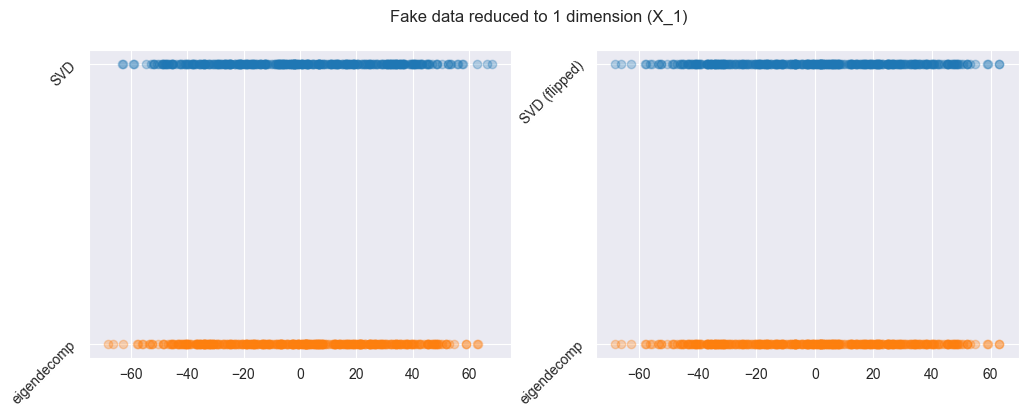

In [26]:
# apply our PCA implementation using svd on the fake data
Xk_svd, PCk_svd = pca_svd(data, k=1)

# direction with most variance computed from PC1
pca_svd_ang = np.abs(np.rad2deg(np.arctan(PCk_svd[1][0]/PCk_svd[0][0])))

#-----------------------------------------------------------------------------
print('---------------------------------------------------------------------')
print("Max var angle (svd):\t {0}".format(pca_svd_ang))
print("Max var angle (eigendecomp):\t {0}".format(pca_eig_ang))
print("Max var angle (iterative algo):\t {0}".format(max_var_ang))

plt.figure(2,figsize = (12,4))

ax = plt.subplot(121)
plt.scatter(Xk_svd , np.ones_like(Xk_svd), alpha = 0.3)
plt.scatter(Xk_eig , np.zeros_like(Xk_eig), alpha = 0.3)
plt.yticks(np.arange(0,2,1))
ax.set_yticklabels(['eigendecomp', 'SVD'], rotation=45)

# flip svd projections and plot
ax = plt.subplot(122)
plt.scatter(Xk_svd * (-1) , np.ones_like(Xk_svd), alpha = 0.3)
plt.scatter(Xk_eig , np.zeros_like(Xk_eig), alpha = 0.3)
plt.yticks(np.arange(0,2,1))
ax.set_yticklabels(['eigendecomp', 'SVD (flipped)'], rotation=45)

plt.suptitle('Fake data reduced to 1 dimension (X_1)')
plt.show()

## Digits Visualization

Try PCA on some images of hand-written digits.

https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits

Size of data (n x m): (1797, 64)
Examples:


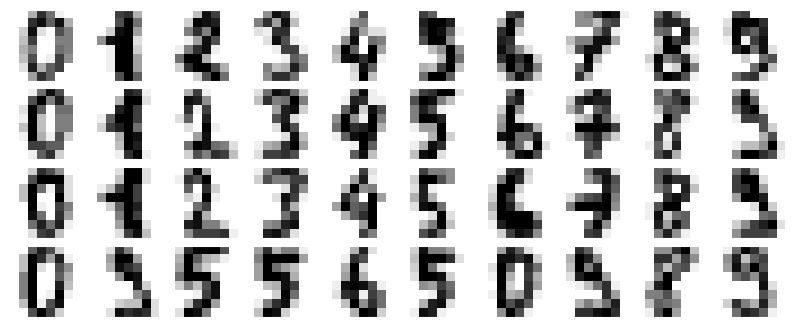

In [22]:
from sklearn.datasets import load_digits
digits = load_digits()

def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

print('Size of data (n x m):', digits.data.shape)
print('Examples:')
plt.show()


Apply PCA to reduce dimension from $m=64$ to $k=2$.

reduced dim (sklearn): (1797, 2)
U shape (1797, 64)
Sigma shape (64,)
Vt shape (64, 64)
reduced dim (ours): (1797, 2)


C:\Users\artem\AppData\Local\Temp\ipykernel_37280\3064384624.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab20', 10))
C:\Users\artem\AppData\Local\Temp\ipykernel_37280\3064384624.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab20', 10))


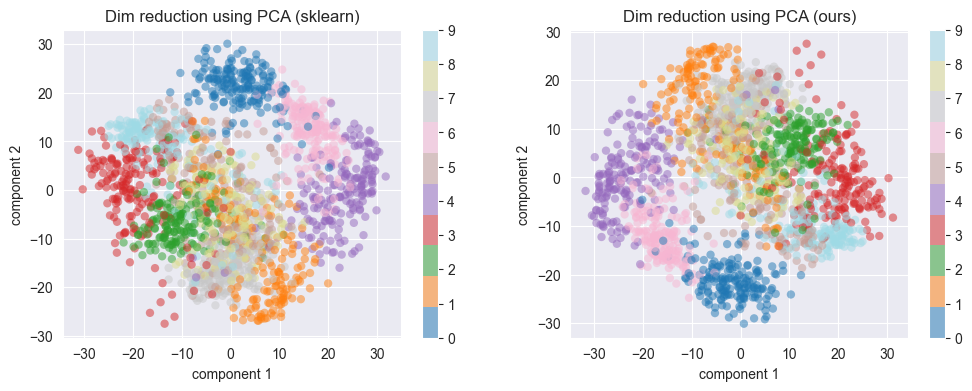

In [23]:
from sklearn.decomposition import PCA

# project from 64 to 2 dimensions using PCA
k = 2 

# using sklearn's implementation 
pca = PCA(k)  
projected_sklearn = pca.fit_transform(digits.data)
print('reduced dim (sklearn):', projected_sklearn.shape)

# using our implementation
projected_ours, pc_ours = pca_svd(digits.data, 2) #using SVD
#projected_ours, pc_ours = pca_eigendecomp(digits.data, 2) #using eigendecomp
print('reduced dim (ours):',projected_ours.shape)


#-----------------------------------------------------------------------------
# plot
plt.figure(2,figsize = (12,4))

ax = plt.subplot(121)
plt.scatter(projected_sklearn[:, 0], projected_sklearn[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('tab20', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Dim reduction using PCA (sklearn)')
plt.colorbar()

ax = plt.subplot(122)
plt.scatter(projected_ours[:, 0], projected_ours[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('tab20', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Dim reduction using PCA (ours)')
plt.colorbar()


plt.show()

C:\Users\artem\AppData\Local\Temp\ipykernel_37280\3602831751.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab20', 10))
C:\Users\artem\AppData\Local\Temp\ipykernel_37280\3602831751.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab20', 10))


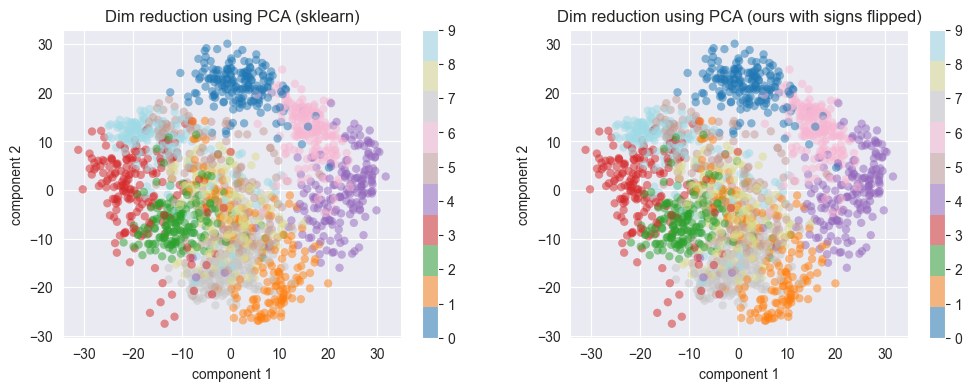

In [24]:
# flip signs for our implementation and plot again

plt.figure(2,figsize = (12,4))

ax = plt.subplot(121)
plt.scatter(projected_sklearn[:, 0], projected_sklearn[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('tab20', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Dim reduction using PCA (sklearn)')
plt.colorbar()

ax = plt.subplot(122)
plt.scatter(projected_ours[:, 0] *(-1), #flip signs
            projected_ours[:, 1] *(-1), #flip signs
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('tab20', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Dim reduction using PCA (ours with signs flipped)')
plt.colorbar()

plt.show()

## Denoising Example

If we add random noise to the data it should not contribute to high variance dimensions. Therefore, PCA can help in denoising the data.

In [ ]:
plot_digits(digits.data)

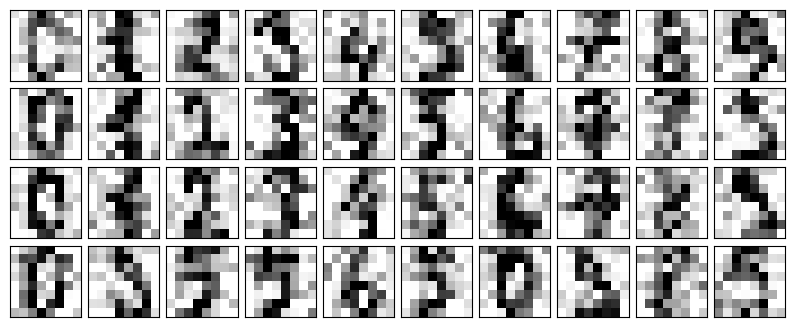

In [ ]:
# add noise

np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

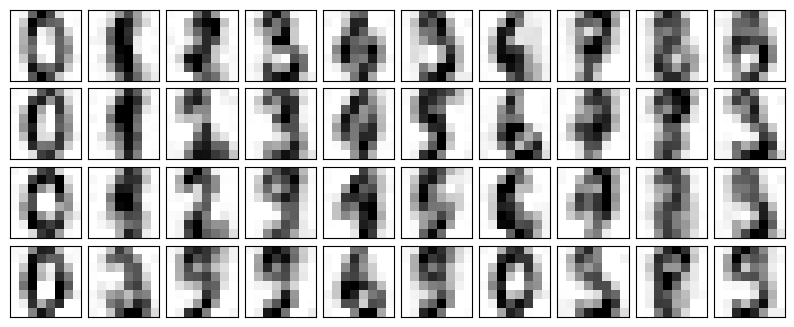

In [ ]:
# use 50% of real dimensions components

pca = PCA(0.4).fit(noisy)
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

## PCA: Face Search Example

In [ ]:
from sklearn.datasets import fetch_lfw_people
#import logging
# Display progress logs on stdout
#logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
lfw_people = fetch_lfw_people(resize=0.4)

In [ ]:
lfw_people.data.shape

(13233, 1850)

(-0.5, 36.5, 49.5, -0.5)

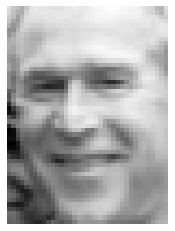

In [ ]:
plt.imshow(lfw_people.images[-10], cmap='Greys_r')
plt.axis('off')

### Run PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)

In [ ]:
pca.fit(lfw_people.data)

PCA(n_components=100)

### Eigen faces

Eigen face is pricipal components after applying PCA on data-set. Intuitively, each eigen face represent a feature set such that their linear combinations can be used to construct any other faces.

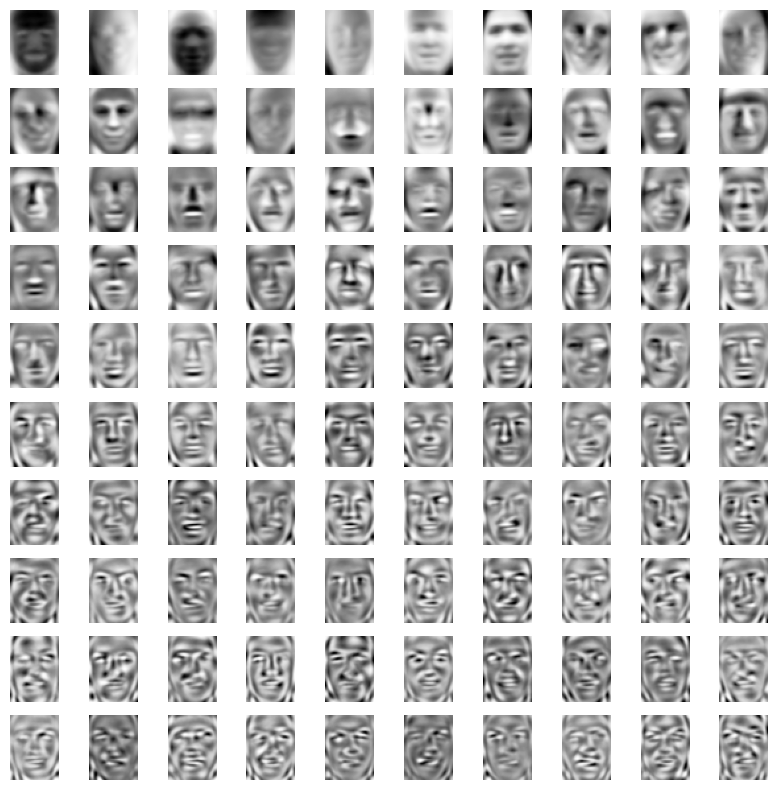

In [ ]:
plt.figure(figsize=(10, 10))
for i, component in enumerate(pca.components_):
    plt.subplot(10, 10, i+1)
    plt.imshow(component.reshape(lfw_people.images[0].shape), cmap='Greys_r')
    plt.axis('off')

### Creating a face mixture of Donald Trump + Paul Martin

In [ ]:
rf = np.zeros((50, 37)) + pca.mean_.reshape(50, 37)
components = pca.transform(lfw_people.data)

In [ ]:
def find_person(name_substr):
    for i, name in enumerate(lfw_people.target_names):
        if name_substr in name:
            print(i, name)

find_person('Donald Trump')
#find_person('Trudeau')
#find_person('Harper')
find_person('Paul Martin')

1405 Donald Trump
4267 Paul Martin


(-0.5, 36.5, 49.5, -0.5)

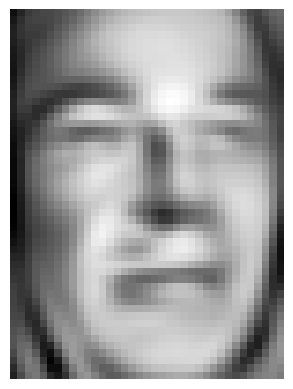

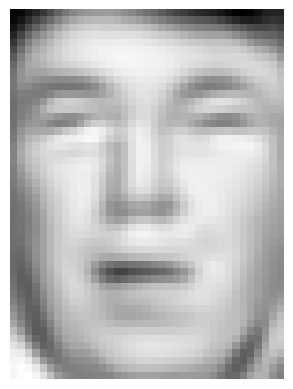

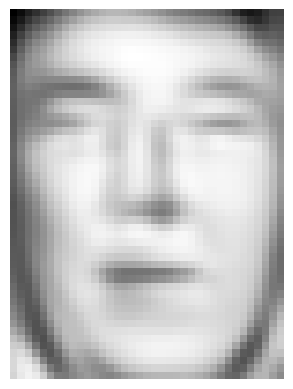

In [ ]:
# Donald Trump + Paul Martin
trumps = lfw_people.data[lfw_people.target == 1405]
martins = lfw_people.data[lfw_people.target == 4267]

np.random.shuffle(trumps)
np.random.shuffle(martins)

plt.figure()
plt.imshow(pca.inverse_transform(pca.transform(martins[0:1])).reshape(50, 37),
           cmap='Greys_r')
plt.axis('off')

plt.figure()
plt.imshow(pca.inverse_transform(pca.transform(trumps[0:1])).reshape(50, 37),
           cmap='Greys_r')
plt.axis('off')

plt.figure()
plt.imshow(pca.inverse_transform((pca.transform(trumps[0:1])
                                  + pca.transform(martins[0:1]))/2.).reshape(50, 37),
           cmap='Greys_r')
plt.axis('off')

### Constructing an external face

In [ ]:
!wget http://dev1-kimia.uwaterloo.ca:5000/data/tut2/me.png

--2023-10-15 21:20:43--  http://dev1-kimia.uwaterloo.ca:5000/data/tut2/me.png
Resolving dev1-kimia.uwaterloo.ca (dev1-kimia.uwaterloo.ca)... 129.97.72.207
Connecting to dev1-kimia.uwaterloo.ca (dev1-kimia.uwaterloo.ca)|129.97.72.207|:5000... 

In [ ]:
from skimage.io import imread
from skimage.transform import resize

im = imread('me.png')
im = np.mean(im, axis=2)
im = resize(im, (50, 37))

plt.imshow(im, cmap='Greys_r')
plt.axis('off')

FileNotFoundError: ignored

In [ ]:
lcp = pca.transform(im.ravel().reshape(1, -1))
plt.imshow(pca.inverse_transform(lcp).reshape(50, 37), cmap='Greys_r')
plt.axis('off')

### Querying the closest faces

In [ ]:
from scipy.spatial import cKDTree

# make a query tree indexing all the PCA reduced faces
pres_query = cKDTree(pca.transform(lfw_people.data))

# query external face (3 closest matches)
_, idxs = pres_query.query(lcp, k=3)
idxs

array([[ 3823,   962, 11522]])

In [ ]:
plt.figure(figsize=(10,5))

# plots the matches
plt.subplot(1, 4, 1)
plt.imshow(im, cmap='Greys_r')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(lfw_people.images[idxs[0][0]], cmap='Greys_r')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(lfw_people.images[idxs[0][1]], cmap='Greys_r')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(lfw_people.images[idxs[0][2]], cmap='Greys_r')
plt.axis('off')

NameError: ignored

#### Searching existing people

[[ 9401  5584  6161  1616  6551  4072  8694  8829 10642  5132]]


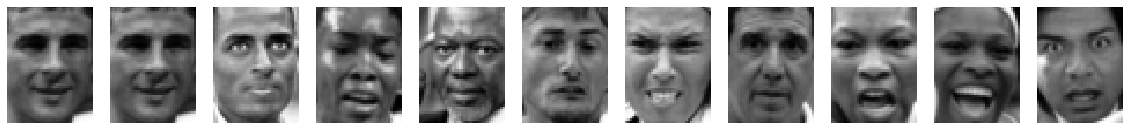

In [ ]:
sidx = np.random.randint(0, len(lfw_people.images))
lcp = pca.transform(lfw_people.data[sidx].reshape(1, -1))

n_query = 10
# query external face (3 closest matches)
_, t_idxs = pres_query.query(lcp, k=n_query)

print(t_idxs)
plt.figure(figsize=(20,10))


# plots the matches
plt.subplot(1, n_query+1, 1)
plt.imshow(lfw_people.images[sidx], cmap='Greys_r')
plt.axis('off')

for i in range(0, n_query):
    plt.subplot(1, n_query+1, i+2)
    plt.imshow(lfw_people.images[t_idxs[0][i]], cmap='Greys_r')
    plt.axis('off')